### 1. Feature Engineering

Bu bölümde, zaman serisi enerji ve hava durumu verilerinden elektrik fiyatını (`price actual`) tahmin edebilmek için yeni öznitelikler oluşturuyorum.

#### Oluşturulan öznitelik türleri:
- Zaman bilgisine dayalı: saat, gün, ay, sin/cos dönüşümleri
- Gecikmeli değerler: önceki saat(ler)e ait fiyat ve tüketim bilgileri
- Rolling istatistikler: ortalama, standart sapma, çarpıklık, basıklık
- Frekans bileşenleri (FFT): periyodik desenleri yakalamak için
- Hedef değişkenin kaydırılmış versiyonu (`target_price`)
- Hava durumu verilerinin eşletirilmesi


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


energy = pd.read_csv('../../data/raw/energy_dataset.csv')
weather = pd.read_csv('../../data/raw/weather_features.csv')

Tahmin edilmek istenen değişken olarak bir saat sonrasının fiyatı (`target_price`) tanımlandı. Bu sayede model geçmiş verilerle bir sonraki fiyatı öngörecek şekilde eğitilecek.

In [2]:
#zaman sırasına göre sıralama ve hedef değişken tanımı
energy = energy.sort_values('time').reset_index(drop=True)
energy['target_price'] = energy['price actual'].shift(-1)#
energy = energy.dropna(subset=['target_price'])

energy['time'] = pd.to_datetime(energy['time'], utc=True)

In [3]:
#zaman bileşenleri
energy['hour'] = energy['time'].dt.hour
energy['day'] = energy['time'].dt.day
energy['weekday'] = energy['time'].dt.weekday
energy['month'] = energy['time'].dt.month

# saat bilgisinin döngüsel kodlaması
energy['hour_sin'] = np.sin(2 * np.pi * energy['hour'] / 24)
energy['hour_cos'] = np.cos(2 * np.pi * energy['hour'] / 24)

# hafta sonu bilgisi
energy['is_weekend'] = energy['weekday'].isin([5, 6]).astype(int)

# mevsim bilgisi (1: kış, 2: ilkbahar, 3: yaz, 4: sonbahar)
def get_season(month):
    return (month % 12 + 3) // 3
energy['season'] = energy['month'].apply(get_season)

ACF/PACF analizlerinde anlamlı olduğu görülen gecikmelere (örneğin 1, 2, 24, 168 saat) göre fiyat ve yük için gecikmeli öznitelikler üretildi.

In [4]:
# EDA'da anlamlı bulunan lag'lar yani 1, 2, 24, 168 saat
for lag in [1, 2, 24, 168]:
    energy[f'price_lag_{lag}'] = energy['price actual'].shift(lag)
    energy[f'load_lag_{lag}'] = energy['total load actual'].shift(lag)

Rolling ortalama ve benzeri işlemlerde yalnızca geçmiş verinin kullanılması sağlandı (`shift(1)` ile), böylece geleceğe ait bilgi modele sızmamış oldu. Bu, veri sızıntısını (data leakage) önlemek için kritik bir adımdır.


In [5]:
for window in [3, 6, 12, 24]:
    energy[f'price_roll_mean_{window}'] = energy['price actual'].shift(1).rolling(window=window).mean()
    energy[f'price_roll_std_{window}'] = energy['price actual'].shift(1).rolling(window=window).std()
    energy[f'load_roll_mean_{window}'] = energy['total load actual'].shift(1).rolling(window=window).mean()
    energy[f'load_roll_std_{window}'] = energy['total load actual'].shift(1).rolling(window=window).std()

In [6]:
#fiyat ve yük değişimleri
energy['price_diff_1'] = energy['price actual'] - energy['price_lag_1']
energy['load_diff_1'] = energy['total load actual'] - energy['load_lag_1']

Fiyat serisinin uç değerlerini azaltmak için log dönüşümü uygulandı. Ayrıca IQR yöntemiyle aykırı değer sınırları hesaplandı.

In [7]:
energy['log_price'] = np.log1p(energy['price actual'])

q1 = energy['price actual'].shift(1).rolling(24).quantile(0.25)
q3 = energy['price actual'].shift(1).rolling(24).quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
energy['is_price_outlier'] = ((energy['price actual'] < lower) | (energy['price actual'] > upper)).astype(int)

In [8]:
def compute_rolling_fft(series, window):
    result = {'fft_mean': [], 'fft_std': [], 'fft_max': []}
    for i in range(len(series)):
        if i < window:
            result['fft_mean'].append(np.nan)
            result['fft_std'].append(np.nan)
            result['fft_max'].append(np.nan)
        else:
            window_data = series.iloc[i - window:i]
            fft_vals = np.fft.fft(window_data.fillna(0).values)
            fft_mag = np.abs(fft_vals)
            result['fft_mean'].append(fft_mag.mean())
            result['fft_std'].append(fft_mag.std())
            result['fft_max'].append(fft_mag.max())
    return result

fft_hourly = compute_rolling_fft(energy['price actual'], window=24)
energy['fft_mean'] = fft_hourly['fft_mean']
energy['fft_std'] = fft_hourly['fft_std']
energy['fft_max'] = fft_hourly['fft_max']


In [9]:
fossil_cols = [
    'generation fossil gas',
    'generation fossil hard coal',
    'generation fossil brown coal/lignite',
    'generation fossil oil',
    'generation fossil oil shale',
    'generation fossil coal-derived gas',
    'generation fossil peat'
]

renewable_cols = [
    'generation hydro water reservoir',
    'generation hydro run-of-river and poundage',
    'generation hydro pumped storage consumption',
    'generation wind onshore',
    'generation wind offshore',
    'generation solar',
    'generation biomass',
    'generation geothermal',
    'generation marine',
    'generation other renewable'
]

other_cols = ['generation nuclear', 'generation waste', 'generation other']

energy['generation_total'] = energy[fossil_cols + renewable_cols + other_cols].sum(axis=1)

#alt gruplar
energy['fossil_total'] = energy[fossil_cols].sum(axis=1)
energy['renewable_total'] = energy[renewable_cols].sum(axis=1)

#oran
energy['fossil_ratio'] = energy['fossil_total'] / (energy['generation_total'] + 1e-6)
energy['renewable_ratio'] = energy['renewable_total'] / (energy['generation_total'] + 1e-6)

def entropy(row):
    p = row / (row.sum() + 1e-6)
    return -(p * np.log(p + 1e-6)).sum()
energy['generation_entropy'] = energy[fossil_cols + renewable_cols + other_cols].apply(entropy, axis=1)

In [10]:
#sabit sütunlar + elle belirlenen gereksiz sütunlar
constant_cols = [col for col in energy.columns if energy[col].nunique() <= 1]
manual_exclude_cols = [
    'generation fossil coal-derived gas',
    'generation fossil oil shale',
    'generation fossil peat',
    'generation geothermal',
    'generation hydro pumped storage aggregated',
    'generation marine',
    'generation wind offshore',
    'forecast wind offshore eday ahead'
]
columns_to_exclude = list(set(constant_cols + manual_exclude_cols))

#sadece sayısal sütunlar içinden korelasyon analizi
numeric_cols = energy.drop(columns=columns_to_exclude, errors='ignore').select_dtypes(include=[np.number])
correlations = numeric_cols.corr()
target_corr = correlations['target_price'].sort_values(ascending=False)

print("Temizlenmiş korelasyon (en anlamlı 40 değişken):")
display(target_corr.head(40))

Temizlenmiş korelasyon (en anlamlı 40 değişken):


target_price                            1.000000
price actual                            0.966788
log_price                               0.940289
price_lag_1                             0.900488
price_roll_mean_3                       0.837791
price_lag_2                             0.821567
price_roll_mean_24                      0.803087
fft_max                                 0.803087
fft_std                                 0.802839
price_lag_24                            0.802259
price_roll_mean_12                      0.778579
price_roll_mean_6                       0.776908
price_lag_168                           0.766502
price day ahead                         0.709791
fft_mean                                0.683677
fossil_total                            0.512998
generation fossil hard coal             0.457324
generation fossil gas                   0.451169
fossil_ratio                            0.435525
total load actual                       0.404124
total load forecast 

## Rolling Window Korelasyon Analizi

Bu aşamada, farklı uzunluktaki geçmiş ortalamaların hedef değişken ile olan korelasyonları incelenmiştir. Hangi pencere genişliğinin (`window size`) öznitelik oluşturmak için daha anlamlı olduğunu belirlemek amaçlanmıştır.


In [11]:
#kKorelasyon analizi için farklı rolling pencereler test edilir
candidate_windows = range(2, 73)
col = 'total load actual'
window_corrs = []

for w in candidate_windows:
    roll_mean = energy[col].rolling(window=w).mean()
    corr = roll_mean.corr(energy['target_price'])
    window_corrs.append((w, corr))

# En yüksek korelasyonlu 5 pencere gösterilir
top_windows = sorted(window_corrs, key=lambda x: abs(x[1]), reverse=True)[:5]
print("Rolling window korelasyonları en yüksek 5:")
for w, c in top_windows:
    print(f"Pencere: {w} saat → Korelasyon: {c:.4f}")

Rolling window korelasyonları en yüksek 5:
Pencere: 2 saat → Korelasyon: 0.3756
Pencere: 3 saat → Korelasyon: 0.3430
Pencere: 4 saat → Korelasyon: 0.3087
Pencere: 5 saat → Korelasyon: 0.2755
Pencere: 6 saat → Korelasyon: 0.2456


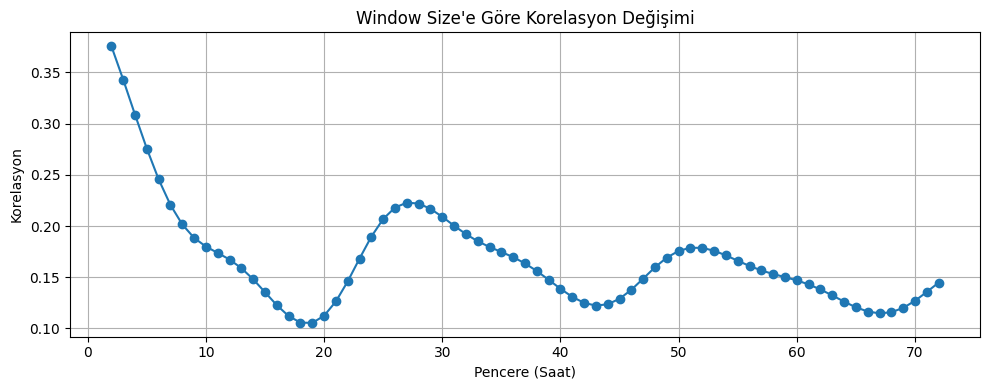

In [12]:
plt.figure(figsize=(10, 4))
plt.plot([w for w, _ in window_corrs], [c for _, c in window_corrs], marker='o')
plt.title("Window Size'e Göre Korelasyon Değişimi")
plt.xlabel("Pencere (Saat)")
plt.ylabel("Korelasyon")
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# # En anlamlı ilk 3 pencere kullanılarak rolling mean ve std hesaplanır
# rolling_windows = [2, 3, 4, 24, 27]


# # Hedefe etkili olabilecek kolonlar seçilir
# rolling_targets = [
#     'price actual',              # Ana değişken, fiyat trendi
#     'total load actual',         # Tüketim trendi
#     'fossil_total',              # Fosil üretim baskısı
#     'renewable_total',           # Yenilenebilir üretim baskısı
#     'generation fossil gas',     # Kritik maliyetli üretim
#     'generation fossil hard coal',  # Önemli bir baz üretim tipi
#     'generation wind onshore',      # Yenilenebilir artışı → fiyat düşürücü etki
#     'price_diff_1',     # Fiyatın ani değişimi → Volatiliteyi rolling ile analiz et
#     'load_diff_1',     # Talep değişiminin penceresel davranışı

# ]


# for col in rolling_targets:
#     for w in rolling_windows:
#         energy[f'{col}_roll{w}_mean'] = energy[col].shift(1).rolling(window=w).mean()
#         energy[f'{col}_roll{w}_std'] = energy[col].shift(1).rolling(window=w).std()
#         energy[f'{col}_roll{w}_min'] = energy[col].shift(1).rolling(window=w).min()
#         energy[f'{col}_roll{w}_max'] = energy[col].shift(1).rolling(window=w).max()

## 2. Weather Verisinin Entegrasyonu (Madrid Örneği)

Bu bölümde, `weather_features.csv` veri setinden EDA'daki analizler sonucunda sadece Madrid şehrine ait veriler alınarak, enerji fiyatlarıyla aynı zaman ekseninde birleştirilecektir.

Madrid seçildi çünküapılan korelasyon analizinde en yüksek ortalama korelasyonu gösteren şehir olmasıdır. Bu şehir üzerinden örnekleme yapılarak model girdi alanı zenginleştirilecektir.


In [14]:
weather['dt_iso'] = pd.to_datetime(weather['dt_iso'], utc=True)

In [15]:
madrid_weather = weather[weather['city_name'] == 'Madrid'].copy()
madrid_weather['dt_iso'] = pd.to_datetime(madrid_weather['dt_iso'], utc=True)

#prefix
madrid_weather = madrid_weather.add_prefix('madrid_')
madrid_weather = madrid_weather.rename(columns={'madrid_dt_iso': 'time'})

#zaman üzerinden birleştir
merged_data= pd.merge(
    energy,
    madrid_weather,
    on='time',
    how='left'
)


In [16]:
print("Yeni shape:", energy.shape)
print("Eklenen weather sütunları:")
print(set(madrid_weather.columns) - {'dt_iso', 'city_name'})

Yeni shape: (35063, 75)
Eklenen weather sütunları:
{'madrid_clouds_all', 'madrid_temp_max', 'madrid_temp_min', 'madrid_pressure', 'madrid_rain_1h', 'madrid_wind_deg', 'madrid_city_name', 'time', 'madrid_snow_3h', 'madrid_weather_id', 'madrid_wind_speed', 'madrid_weather_description', 'madrid_temp', 'madrid_rain_3h', 'madrid_weather_main', 'madrid_humidity', 'madrid_weather_icon'}


In [17]:
# 3 saatlik sıcaklık farkı
merged_data['madrid_temp_diff_3h'] = merged_data['madrid_temp'] - merged_data['madrid_temp'].shift(3)

#yağmur ve kar var mı
merged_data['madrid_is_rainy'] = (merged_data['madrid_rain_3h'] > 0).astype(int)
merged_data['madrid_is_snowy'] = (merged_data['madrid_snow_3h'] > 0).astype(int)

#rüzgar gücü yaklaşık tahmini
merged_data['madrid_wind_power_proxy'] = (merged_data['madrid_wind_speed'] ** 3).fillna(0)

#bulutluluk oranı
merged_data['madrid_cloud_ratio'] = merged_data['madrid_clouds_all'] / 100.0

#rolling öznitelikler (trend ve volatilite göstergesi)
merged_data['madrid_temp_roll3_mean'] = merged_data['madrid_temp'].shift(1).rolling(window=3).mean()
merged_data['madrid_humidity_roll3_std'] = merged_data['madrid_humidity'].shift(1).rolling(window=3).std()

In [18]:
#korelasyon analizi

weather_cols = [
    col for col in merged_data.columns 
    if col.startswith('madrid_') and np.issubdtype(merged_data[col].dtype, np.number)
]

corrs = merged_data[weather_cols].corrwith(merged_data['target_price']).abs().sort_values(ascending=False)
display(corrs)
# Sadece madrid_ ile başlayan ve sayısal olan sütunları al
weather_cols = [
    col for col in merged_data.columns 
    if col.startswith('madrid_') and np.issubdtype(merged_data[col].dtype, np.number)
]

corrs = merged_data[weather_cols].corrwith(merged_data['target_price']).abs().sort_values(ascending=False)
display(corrs)

madrid_wind_speed            0.245752
madrid_wind_power_proxy      0.202800
madrid_temp_diff_3h          0.108674
madrid_wind_deg              0.084786
madrid_temp_max              0.077963
madrid_temp                  0.068884
madrid_cloud_ratio           0.052271
madrid_clouds_all            0.052271
madrid_temp_min              0.047301
madrid_temp_roll3_mean       0.044075
madrid_humidity              0.042200
madrid_is_rainy              0.033056
madrid_rain_3h               0.026750
madrid_pressure              0.020311
madrid_rain_1h               0.011597
madrid_humidity_roll3_std    0.009149
madrid_snow_3h               0.007970
madrid_is_snowy              0.007970
madrid_weather_id            0.001094
dtype: float64

madrid_wind_speed            0.245752
madrid_wind_power_proxy      0.202800
madrid_temp_diff_3h          0.108674
madrid_wind_deg              0.084786
madrid_temp_max              0.077963
madrid_temp                  0.068884
madrid_cloud_ratio           0.052271
madrid_clouds_all            0.052271
madrid_temp_min              0.047301
madrid_temp_roll3_mean       0.044075
madrid_humidity              0.042200
madrid_is_rainy              0.033056
madrid_rain_3h               0.026750
madrid_pressure              0.020311
madrid_rain_1h               0.011597
madrid_humidity_roll3_std    0.009149
madrid_snow_3h               0.007970
madrid_is_snowy              0.007970
madrid_weather_id            0.001094
dtype: float64

In [19]:
#hedefe etkili olabilecek kolonlar seçilir
target_columns = [
    'price actual',            
    'total load actual',         # Tüketim trendi
    'fossil_total',              
    'renewable_total',           # Yenilenebilir üretim baskısı
    'generation fossil gas',     
    'generation fossil hard coal',  # Önemli bir baz üretim tipi
    'generation wind onshore',      # Yenilenebilir artışı
    'price_diff_1',     # Fiyatın ani değişimi
    'load_diff_1',       
    'madrid_wind_speed',       
    'madrid_temp',             
]

candidate_windows = range(2, 73)
rolling_corr_results = {}

for col in target_columns:
    correlations = []
    for w in candidate_windows:
        rolling_series = merged_data[col].shift(1).rolling(window=w).mean()
        corr = rolling_series.corr(merged_data['target_price'].shift(1))
        correlations.append((w, corr))
    rolling_corr_results[col] = sorted(correlations, key=lambda x: abs(x[1]), reverse=True)[:5]


In [20]:
print("Rolling pencere korelasyon sonuçları (ilk 5 pencere):\n")
for col, top_corrs in rolling_corr_results.items():
    print(f"{col}:")
    for w, c in top_corrs:
        print(f"  Pencere: {w} saat → Korelasyon: {c:.4f}")
    print("-" * 40)


Rolling pencere korelasyon sonuçları (ilk 5 pencere):

price actual:
  Pencere: 2 saat → Korelasyon: 0.9423
  Pencere: 3 saat → Korelasyon: 0.9150
  Pencere: 4 saat → Korelasyon: 0.8877
  Pencere: 5 saat → Korelasyon: 0.8627
  Pencere: 6 saat → Korelasyon: 0.8417
----------------------------------------
total load actual:
  Pencere: 2 saat → Korelasyon: 0.3799
  Pencere: 3 saat → Korelasyon: 0.3485
  Pencere: 4 saat → Korelasyon: 0.3154
  Pencere: 5 saat → Korelasyon: 0.2833
  Pencere: 6 saat → Korelasyon: 0.2541
----------------------------------------
fossil_total:
  Pencere: 2 saat → Korelasyon: 0.5003
  Pencere: 3 saat → Korelasyon: 0.4866
  Pencere: 4 saat → Korelasyon: 0.4716
  Pencere: 5 saat → Korelasyon: 0.4565
  Pencere: 6 saat → Korelasyon: 0.4425
----------------------------------------
renewable_total:
  Pencere: 18 saat → Korelasyon: -0.3148
  Pencere: 19 saat → Korelasyon: -0.3142
  Pencere: 17 saat → Korelasyon: -0.3135
  Pencere: 20 saat → Korelasyon: -0.3120
  Pencere

In [21]:
rolling_config = {
    'price actual': [2, 3, 4],
    'total load actual': [2, 3],
    'fossil_total': [2, 3, 4],
    'renewable_total': [16, 17, 18],
    'price_diff_1': [52, 53],
    'generation fossil gas': [2, 3],
    'generation fossil hard coal': [2, 3],
    'generation wind onshore': [6, 7],
    'madrid_wind_speed': [14, 15],
}
for col, window_list in rolling_config.items():
    for w in window_list:
        merged_data[f'{col}_roll{w}_mean'] = merged_data[col].shift(1).rolling(window=w).mean()
        merged_data[f'{col}_roll{w}_std'] = merged_data[col].shift(1).rolling(window=w).std()


In [22]:
merged_data['price_load_interaction'] = merged_data['price_lag_1'] * merged_data['total load actual']
merged_data['load_ratio_fossil'] = merged_data['total load actual'] / (merged_data['fossil_total'] + 1e-6)

merged_data['fossil_vs_renewable'] = merged_data['fossil_total'] - merged_data['renewable_total']
merged_data['fossil_renewable_ratio'] = merged_data['fossil_total'] / (merged_data['renewable_total'] + 1e-6)

merged_data['wind_effect'] = merged_data['madrid_wind_speed'] * merged_data['generation wind onshore']
merged_data['rain_demand_interaction'] = merged_data['madrid_is_rainy'] * merged_data['total load actual']

merged_data['price_volatility_fossil'] = merged_data['price_diff_1'] * merged_data['fossil_ratio']

merged_data['snow_load_effect'] = merged_data['madrid_is_snowy'] * merged_data['total load actual']

In [23]:
#FFT ile frekans bileşenleri çıkarımı

from scipy.fftpack import fft
import numpy as np

def compute_fft_features(series, n_freq=5):
    fft_vals = np.abs(fft(series.values))
    fft_energy = np.sum(fft_vals**2)
    top_freqs = np.sort(fft_vals)[-n_freq:]
    return list(top_freqs) + [fft_energy]

fft_features = []
window_size = 24

for i in range(window_size, len(merged_data)):
    window = merged_data['price actual'].iloc[i - window_size:i]
    features = compute_fft_features(window)
    fft_features.append(features)

fft_cols = [f'fft_peak_{i+1}' for i in range(5)] + ['fft_energy']
fft_df = pd.DataFrame(fft_features, columns=fft_cols, index=merged_data.index[window_size:])
merged_data = merged_data.join(fft_df)

In [24]:
# Haar benzeri manuel wavelet dönüşümü

def haar_transform(series):
    n = len(series) // 2 * 2
    series = series[:n]
    approx = [(series[i] + series[i+1]) / 2 for i in range(0, n, 2)]
    detail = [(series[i] - series[i+1]) / 2 for i in range(0, n, 2)]
    return np.mean(approx), np.std(approx), np.mean(detail), np.std(detail)

haar_features = []

for i in range(window_size, len(merged_data)):
    window = merged_data['price actual'].iloc[i - window_size:i].values
    features = haar_transform(window)
    haar_features.append(features)

haar_cols = ['dwt_approx_mean', 'dwt_approx_std', 'dwt_detail_mean', 'dwt_detail_std']
haar_df = pd.DataFrame(haar_features, columns=haar_cols, index=merged_data.index[window_size:])
merged_data = merged_data.join(haar_df)


In [25]:
# 1. %100 eksik sütunları çıkarılır
merged_data = merged_data.drop(columns=[
    'generation hydro pumped storage aggregated',
    'forecast wind offshore eday ahead'
])

# 2. Üretimle ilgili eksik sütunları 0 ile doldurulur
fill_zero_cols = [col for col in merged_data.columns if 'generation' in col and merged_data[col].isnull().sum() > 0]
merged_data[fill_zero_cols] = merged_data[fill_zero_cols].fillna(0)

# 3. Geri kalan eksik veriyi modelleme sırasında dropna() ile temizleyeceğiz


Modelleme öncesinde, hedef değişken (`target_price`) ve doğrudan onunla ilişkili sütunlar (`price actual`, `time` gibi) eğitim verisinden çıkarıldı. Bu, modelin gelecek bilgiye erişmesini (data leakage) engellemek için çıkarıldı.

In [26]:
exclude_cols = [
    'target_price', 'time', 'dt_iso',
    'price actual',
]
features = [
    col for col in merged_data.columns
    if col not in exclude_cols and np.issubdtype(merged_data[col].dtype, np.number)
]

In [27]:
merged_data.to_csv("../../data/processed/merged_with_weather.csv", index=False)

In [28]:
import pandas as pd
import numpy as np

# Veriyi oku
df = pd.read_csv("../../data/processed/merged_with_weather.csv", parse_dates=["time"])
df = df.sort_values("time").reset_index(drop=True)

# Temel bilgi analizi
print("Veri Özeti:")
print(f"Satır Sayısı: {len(df)}")
print(f"Zaman Aralığı: {df['time'].min()} → {df['time'].max()}")
print(f"Toplam Eksik Değer Sayısı: {df.isnull().sum().sum()}")

# Hedef değişken kontrolü
if "target_price" not in df.columns:
    raise ValueError("target_price sütunu bulunamadı!")
print("\nHedef Değişken (target_price) Özet İstatistikleri:")
print(df["target_price"].describe())

# Train/Val/Test oranları
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

n_total = len(df)
n_train = int(n_total * train_ratio)
n_val = int(n_total * val_ratio)

# Bölme işlemi
df_train = df.iloc[:n_train].copy()
df_val   = df.iloc[n_train:n_train + n_val].copy()
df_test  = df.iloc[n_train + n_val:].copy()

# Her parça için bilgi verelim
def summarize_part(part, name):
    print(f"\n{name.upper()} ({len(part)} satır)")
    print(f"Zaman Aralığı: {part['time'].min()} → {part['time'].max()}")
    print(f"target_price min: {part['target_price'].min():.2f}, max: {part['target_price'].max():.2f}")

summarize_part(df_train, "Train")
summarize_part(df_val, "Validation")
summarize_part(df_test, "Test")


Veri Özeti:
Satır Sayısı: 36266
Zaman Aralığı: 2014-12-31 23:00:00+00:00 → 2018-12-31 21:00:00+00:00
Toplam Eksik Değer Sayısı: 3841

Hedef Değişken (target_price) Özet İstatistikleri:
count    36266.000000
mean        58.036392
std         14.196357
min          9.330000
25%         49.522500
50%         58.190000
75%         68.190000
max        116.800000
Name: target_price, dtype: float64

TRAIN (25386 satır)
Zaman Aralığı: 2014-12-31 23:00:00+00:00 → 2017-11-02 10:00:00+00:00
target_price min: 9.33, max: 116.80

VALIDATION (5439 satır)
Zaman Aralığı: 2017-11-02 11:00:00+00:00 → 2018-05-30 14:00:00+00:00
target_price min: 10.66, max: 99.95

TEST (5441 satır)
Zaman Aralığı: 2018-05-30 14:00:00+00:00 → 2018-12-31 21:00:00+00:00
target_price min: 37.76, max: 91.93


In [29]:
target_col = "target_price"

# Modelde kullanmayacağımız sızıntı riski olduğu düşünülen sütunlar çıkartılır
drop_cols = [
    "time",                            # zaman bilgisi (ID gibi düşünülebilir)
    "price actual",                    # hedef değişkenle birebir ilişkili, leakage riski
    "forecast price day ahead",       # geleceğe ait dışsal bilgi, tahmine dahil edilmemeli
    "target_price",                   # zaten tahmin edilen hedef
    "log_target_price",               # hedefin logaritması, doğrudan bilgi içeriyor
    "price actual_roll2_mean",        # hedefle çok yakın zamanlı ve orijinal fiyat üzerinden
    "price actual_roll2_std",
    "price actual_roll3_mean",
    "price actual_roll3_std",
    "price actual_roll4_mean",
    "price actual_roll4_std",
    "is_price_outlier",               # doğrudan hedefe dayalı olarak belirlenmiş (IQR yöntemiyle)
    "fft_mean",                       # hedefin FFT dönüşümünden gelen, modelin tahmin edeceği bilgi olabilir
    "fft_std",
    "fft_max",
    "fft_peak_1", "fft_peak_2", "fft_peak_3", "fft_peak_4", "fft_peak_5",
    "fft_energy",
    "log_price",                      # `price actual` üzerinden gelen türev bilgi (tartışmalı ama dikkatli olunmalı)
    "price_day_ahead"
]


feature_cols = [col for col in df_train.columns if col not in drop_cols]

print(f"Toplam {len(feature_cols)} adet öznitelik kullanılacak.")


# girdi ve hedef setlerini oluşturulur
X_train = df_train[feature_cols].copy()
X_val   = df_val[feature_cols].copy()
X_test  = df_test[feature_cols].copy()

y_train = df_train[target_col].copy()
y_val   = df_val[target_col].copy()
y_test  = df_test[target_col].copy()

print("\nGirdi ve hedef ayrımı tamamlandı.")



Toplam 136 adet öznitelik kullanılacak.

Girdi ve hedef ayrımı tamamlandı.


In [30]:
#eksik veri analizi
def missing_report(df, name):
    null_counts = df[feature_cols].isnull().sum()
    missing = null_counts[null_counts > 0].sort_values(ascending=False)
    if len(missing) == 0:
        print(f"{name}: Eksik veri yok.")
    else:
        print(f"{name} eksik veri durumu:\n{missing}")

missing_report(df_train, "Train")
missing_report(df_val, "Validation")
missing_report(df_test, "Test")

#sayısal ve kategorik ayrımı
numeric_cols = df_train[feature_cols].select_dtypes(include=["float64", "int64"]).columns.tolist()
categorical_cols = list(set(feature_cols) - set(numeric_cols))

print(f"\nSayısal sütun sayısı: {len(numeric_cols)}")
print(f"Kategorik (sayısal olmayan) sütun sayısı: {len(categorical_cols)}")


if categorical_cols:
    print(f"Kategorik sütunlar: {categorical_cols}")


Train eksik veri durumu:
load_roll_std_24           406
load_roll_mean_24          406
load_roll_mean_12          214
load_roll_std_12           214
load_lag_168               200
                          ... 
fossil_total_roll2_mean      2
fossil_total_roll2_std       2
price_lag_1                  1
price_diff_1                 1
price_volatility_fossil      1
Length: 64, dtype: int64
Validation eksik veri durumu:
load_roll_mean_24               31
load_roll_std_24                31
load_roll_std_12                19
load_roll_mean_12               19
load_roll_std_6                 12
load_roll_mean_6                12
total load actual_roll3_mean     6
load_roll_mean_3                 6
load_roll_std_3                  6
total load actual_roll3_std      6
total load actual_roll2_std      4
load_diff_1                      4
total load actual_roll2_mean     4
total load actual                2
load_lag_168                     2
load_lag_24                      2
load_lag_2         

Eksik değerler sadece eğitim verisinin ortalamalarıyla dolduruldu. Bu sayede doğrulama ve test setlerinin içeriğine dair bilgi modele sızmamış oldu.

In [31]:
# Kategorik sütunları çıkar
X_train = X_train.drop(columns=categorical_cols)
X_val   = X_val.drop(columns=categorical_cols)
X_test  = X_test.drop(columns=categorical_cols)

# Ortalamaları sadece TRAIN setinden al
fill_values = X_train.mean()

# Eksik değerleri doldur
X_train = X_train.fillna(fill_values)
X_val   = X_val.fillna(fill_values)
X_test  = X_test.fillna(fill_values)

print("Eksik veri temizliği tamamlandı.")
print(f"X_train null? {X_train.isnull().sum().sum()}")
print(f"X_val null?   {X_val.isnull().sum().sum()}")
print(f"X_test null?  {X_test.isnull().sum().sum()}")

Eksik veri temizliği tamamlandı.
X_train null? 0
X_val null?   0
X_test null?  0


In [32]:
from sklearn.preprocessing import StandardScaler

#StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("Normalizasyon tamamlandı.")
print(f"Ortalama (train): {X_train_scaled.mean():.4f}")
print(f"Std (train): {X_train_scaled.std():.4f}")


Normalizasyon tamamlandı.
Ortalama (train): -0.0000
Std (train): 0.9770


Veri, doğrusal ve derin öğrenme modelleri için normalize edildi. Sadece eğitim verisiyle `fit` edilerek doğrulama ve test setlerine uygulandı.

In [33]:
import joblib
import os
import pandas as pd # Gerekirse diye ekleyelim


# Kategorik sütunları çıkar 
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
X_train = X_train.drop(columns=categorical_cols)
X_val   = X_val.drop(columns=categorical_cols)
X_test  = X_test.drop(columns=categorical_cols)

# Eksik değerleri doldur
fill_values = X_train.mean()
X_train = X_train.fillna(fill_values)
X_val   = X_val.fillna(fill_values)
X_test  = X_test.fillna(fill_values)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


print(f"X_train (ölçeklenmemiş) son boyutu: {X_train.shape}")
print(f"X_train_scaled (ölçeklenmiş) son boyutu: {X_train_scaled.shape}")
print("-" * 50)


os.makedirs("models", exist_ok=True)

train_columns = X_train.columns.tolist()
joblib.dump(train_columns, "models/train_columns.pkl")
print(f"{len(train_columns)} adet eğitim sütunu 'models/train_columns.pkl' dosyasına kaydedildi.")

# Scaled (MLP için)
joblib.dump(X_train_scaled, "models/X_train_scaled.pkl")
joblib.dump(X_val_scaled,   "models/X_val_scaled.pkl")
joblib.dump(X_test_scaled,  "models/X_test_scaled.pkl")

# Unscaled (Tree modeller için) - Artık sütun listesiyle senkronize
joblib.dump(X_train, "models/X_train.pkl")
joblib.dump(X_val,   "models/X_val.pkl")
joblib.dump(X_test,  "models/X_test.pkl")

# Hedef değişkenler
joblib.dump(y_train, "models/y_train.pkl")
joblib.dump(y_val,   "models/y_val.pkl")
joblib.dump(y_test,  "models/y_test.pkl")

# Scaler
joblib.dump(scaler, "models/scaler.pkl")

print("\nTüm veri nesneleri models/ klasörüne yeniden ve doğru sırayla kaydedildi.")

X_train (ölçeklenmemiş) son boyutu: (25386, 132)
X_train_scaled (ölçeklenmiş) son boyutu: (25386, 132)
--------------------------------------------------
132 adet eğitim sütunu 'models/train_columns.pkl' dosyasına kaydedildi.

Tüm veri nesneleri models/ klasörüne yeniden ve doğru sırayla kaydedildi.


Genel Değerlendirme

Bu bölümde yaptığım öznitelik mühendisliği sayesinde zaman serisi verisinden pek çok anlamlı bilgi çıkarmış oldum. Zaman, tüketim ve geçmiş fiyat bilgilerini kullanarak modelin tahmin gücünü artırabilecek özellikler üretildi.

Özellikle:
- Gecikmeli değerler (lag) ile kısa ve uzun vadeli bağımlılıklar yakalandı,
- Rolling istatistikler ile fiyat ve tüketimdeki lokal desenler ortaya kondu,
- Saat bilgisi sin/cos dönüşümüyle döngüsel olarak temsil edildi,
- Log dönüşümü ve IQR ile aykırı değerler kontrol altına alındı,
- FFT ile zaman serisindeki gizli periyodik yapılar tanımlandı.

Bu öznitelikler, sonraki aşamada modelin hem daha doğru hem de daha kararlı tahminler yapmasına katkı sağlayacaktır.